# Risk Index

In [1]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

%load_ext autoreload
%autoreload 2
import pre_ml
import mlpipeline

In [2]:
covid = pre_ml.data()

print(covid.shape)
covid.head(5)

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory
(129184, 21)


,entidad_res,municipio_res,CVE_MUN,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,...,obesidad,tabaquismo,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras,hospitalizado,muertos,covid_grave
0,15,106,15106,0.0,53,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,38.0,2094.442483,2.339428,12.656094,33.584488,0,0,0
1,15,106,15106,0.0,59,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,38.0,2094.442483,2.339428,12.656094,33.584488,1,0,1
2,9,7,9007,0.0,34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,36.4,16028.524764,2.170140,7.325600,17.785234,0,0,0
3,2,4,2004,0.0,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.1,1449.318075,0.726447,4.889549,11.701390,0,0,0
4,15,58,15058,0.0,53,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,37.4,17954.252292,0.810012,2.870259,10.248409,1,0,1


# Death

In [3]:
train, test = mlpipeline.split_data(covid, 0.2, 1)
print(train.shape)

train_n, test_n = mlpipeline.normalize(train, test, ['edad', 'pobreza', 'Densidad_pob', 'medicos',
                                                            'camas_hosp', 'enfermeras'])

(103347, 21)


In [4]:
# Balance Random Forest Model
from imblearn.ensemble import BalancedRandomForestClassifier
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['muertos']

params = {'criterion':['gini', 'entropy'], 'max_depth':[5,10, 15],
         'min_samples_split':[10, 15]}       
grid_parameters={'estimator':BalancedRandomForestClassifier(random_state=0), 
                          'param_grid':params, 
                          'cv':10,
                          'return_train_score':True,
                          'scoring':['recall', 'precision', 'accuracy'],
                           'refit' : 'recall'}
grid_d = GridSearchCV(**grid_parameters)
grid_d.fit(train_n[features].values, train_n[target].values.ravel())
results = pd.DataFrame(grid_d.cv_results_)

best_model = grid_d.best_estimator_

pred = grid_d.predict(test_n[features]) # predictions!!!

results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.673324,0.241858,0.815016
1,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.673421,0.241845,0.814610
2,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.686783,0.249760,0.811932
3,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.688303,0.250567,0.810877
4,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.697785,0.255493,0.801867
5,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.697243,0.255383,0.803571
6,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.669860,0.240493,0.819562
7,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.670044,0.240602,0.819643
8,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.688351,0.250606,0.810958
9,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.686522,0.249919,0.813880


In [5]:
# add column of predictions to test data
covid_pred = test.copy()
covid_pred['pred'] = pred

In [6]:
# group by state and get the percentage of predicted deaths

covid_state = covid_pred.groupby('entidad_res').agg({'municipio_res': 'count', 
                                          'pred':'sum'}).reset_index().rename(columns={'municipio_res': 'count', 'pred': 'pred_dead'})
covid_state['pred_nodead'] = covid_state['count'] - covid_state['pred_dead']
covid_state['percent_dead'] = covid_state['pred_dead'] / covid_state['count']
covid_state['percent_dead_norm'] = (covid_state['percent_dead'] - covid_state['percent_dead'].mean()) /covid_state['percent_dead'].std()


#Add state name
xls = 'data/description_catalogue_covid_mx.xlsx'
state_codes = pd.read_excel(xls, sheet_name='Catálogo de ENTIDADES')

covid_state = state_codes.merge(covid_state, right_on='entidad_res', 
                                     left_on='CLAVE_ENTIDAD').loc[:,'ABREVIATURA':]

covid_state = covid_state.sort_values(by='entidad_res')

#Get geometry of each state and group daily data by state
pd.options.mode.chained_assignment = None 
shape = gpd.read_file('data/mex_states_shape/mex_admbnda_adm1_govmex.shp')
states_shape = shape.loc[:,['ADM1_ES', 'ADM1_PCODE', 'geometry']]
states_shape.loc[:,'ADM1_PCODE'] = states_shape.ADM1_PCODE.apply(lambda row: 
                                                                 int(row.strip('MX')))

state_gdf = states_shape.merge(covid_state, right_on='entidad_res', 
                                     left_on='ADM1_PCODE').loc[:,'geometry':]


state_gdf.head()

,geometry,ABREVIATURA,entidad_res,count,pred_dead,pred_nodead,percent_dead,percent_dead_norm
0,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",AS,1,259,69,190,0.266409,-1.694327
1,"MULTIPOLYGON (((-114.12880 28.01224, -114.1283...",BC,2,1290,674,616,0.522481,1.742707
2,"MULTIPOLYGON (((-109.91027 22.87937, -109.9102...",BS,3,188,45,143,0.239362,-2.057364
3,"MULTIPOLYGON (((-91.55142 18.28699, -91.55248 ...",CC,4,166,62,104,0.373494,-0.257017
4,"MULTIPOLYGON (((-92.77034 15.15128, -92.77107 ...",CS,7,563,235,328,0.417407,0.332387


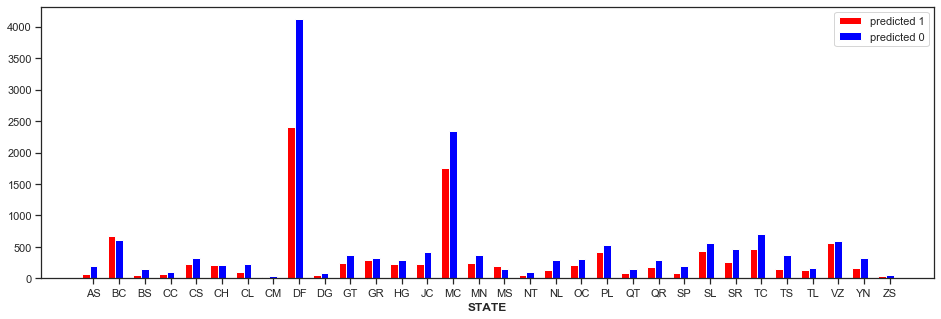

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 5)})
sns.set_style("ticks")

# set width of bar
barWidth = 0.30
 
# set height of bar
bars1 = state_gdf['pred_dead'].values
bars2 = state_gdf['pred_nodead'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='predicted 1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='predicted 0')
 
# Add xticks on the middle of the group bars
plt.xlabel('STATE', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], state_gdf['ABREVIATURA'].values)
 
# Create legend & Show graphic
plt.legend()
plt.show()

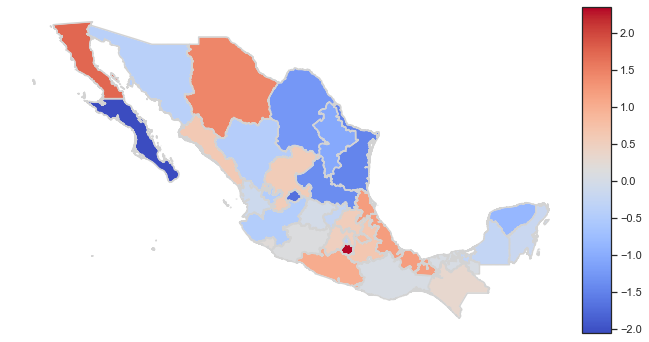

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,6))
#ax.set_title('Relative Risk by State: Deaths')
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = state_gdf.plot(column='percent_dead_norm', cmap='coolwarm', legend=True,
                          ax=ax, cax=cax)
state_gdf.boundary.plot(color='lightgrey',ax =ax)
fig.savefig('map_risk_deaths.png')

# Hospitalization

In [15]:
from sklearn.svm import LinearSVC
# model
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['hospitalizado']

pipeline = make_pipeline((SMOTE(random_state=0)), LinearSVC(random_state=0, max_iter=10000, dual=False))

#model
params = {'linearsvc__penalty': ['l1','l2'],
          'linearsvc__C': [0.1, 1, 10, 100]}

grid_h = GridSearchCV(estimator=pipeline,
                    param_grid=params,
                    cv=10,
                    return_train_score=True,
                    scoring= ['accuracy', 'precision', 'recall'],
                    refit = 'recall')

grid_h.fit(train_n[features].values, train_n[target].values.ravel())
results = pd.DataFrame(grid_h.cv_results_)

best_model = grid_h.best_estimator_.get_params()['steps'][1][1]

pred = grid_h.predict(test_n[features]) # predictions!!!

results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'linearsvc__C': 0.1, 'linearsvc__penalty': 'l1'}",0.711341,0.552897,0.670884
1,"{'linearsvc__C': 0.1, 'linearsvc__penalty': 'l2'}",0.711274,0.552813,0.670768
2,"{'linearsvc__C': 1, 'linearsvc__penalty': 'l1'}",0.711274,0.552813,0.670768
3,"{'linearsvc__C': 1, 'linearsvc__penalty': 'l2'}",0.711293,0.552840,0.670768
4,"{'linearsvc__C': 10, 'linearsvc__penalty': 'l1'}",0.711274,0.552818,0.670709
5,"{'linearsvc__C': 10, 'linearsvc__penalty': 'l2'}",0.711293,0.552840,0.670768
6,"{'linearsvc__C': 100, 'linearsvc__penalty': 'l1'}",0.711274,0.552818,0.670709
7,"{'linearsvc__C': 100, 'linearsvc__penalty': 'l2'}",0.711293,0.552840,0.670768


In [16]:
# add column of predictions to test data
covid_pred = test.copy()
covid_pred['pred'] = pred

# group by state and get the percentage of predicted deaths
covid_state = covid_pred.groupby('entidad_res').agg({'municipio_res': 'count', 
                                          'pred':'sum'}).reset_index().rename(columns={'municipio_res': 'count', 'pred': 'pred_hosp'})
covid_state['pred_nohosp'] = covid_state['count'] - covid_state['pred_hosp']
covid_state['percent_hosp'] = covid_state['pred_hosp'] / covid_state['count']
covid_state['percent_hosp_norm'] = (covid_state['percent_hosp'] - covid_state['percent_hosp'].mean()) /covid_state['percent_hosp'].std()


#Add state name
xls = 'data/description_catalogue_covid_mx.xlsx'
state_codes = pd.read_excel(xls, sheet_name='Catálogo de ENTIDADES')

covid_state = state_codes.merge(covid_state, right_on='entidad_res', 
                                     left_on='CLAVE_ENTIDAD').loc[:,'ABREVIATURA':]

covid_state = covid_state.sort_values(by='entidad_res')

#Get geometry of each state and group daily data by state
pd.options.mode.chained_assignment = None 
shape = gpd.read_file('data/mex_states_shape/mex_admbnda_adm1_govmex.shp')
states_shape = shape.loc[:,['ADM1_ES', 'ADM1_PCODE', 'geometry']]
states_shape.loc[:,'ADM1_PCODE'] = states_shape.ADM1_PCODE.apply(lambda row: 
                                                                 int(row.strip('MX')))

state_gdf = states_shape.merge(covid_state, right_on='entidad_res', 
                                     left_on='ADM1_PCODE').loc[:,'geometry':]


state_gdf.head()

,geometry,ABREVIATURA,entidad_res,count,pred_hosp,pred_nohosp,percent_hosp,percent_hosp_norm
0,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",AS,1,259,70,189,0.270270,-1.628909
1,"MULTIPOLYGON (((-114.12880 28.01224, -114.1283...",BC,2,1290,633,657,0.490698,1.306826
2,"MULTIPOLYGON (((-109.91027 22.87937, -109.9102...",BS,3,188,41,147,0.218085,-2.323930
3,"MULTIPOLYGON (((-91.55142 18.28699, -91.55248 ...",CC,4,166,50,116,0.301205,-1.216911
4,"MULTIPOLYGON (((-92.77034 15.15128, -92.77107 ...",CS,7,563,257,306,0.456483,0.851144


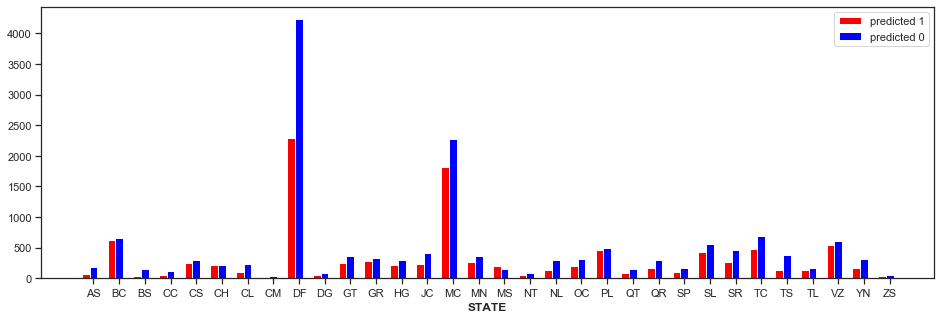

In [17]:
sns.set(rc={'figure.figsize':(16, 5)})
sns.set_style("ticks")

# set width of bar
barWidth = 0.30
 
# set height of bar
bars1 = state_gdf['pred_hosp'].values
bars2 = state_gdf['pred_nohosp'].values
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='predicted 1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='predicted 0')
 
# Add xticks on the middle of the group bars
plt.xlabel('STATE', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], state_gdf['ABREVIATURA'].values)
 
# Create legend & Show graphic
plt.legend()
plt.show()

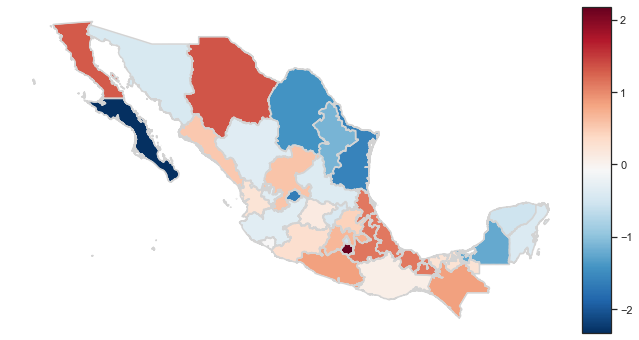

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
#ax.set_title('Relative Risk by State: Hospitalization')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.axis('off')
ax = state_gdf.plot(column='percent_hosp_norm', cmap='RdBu_r', legend=True,
                          ax=ax, cax=cax)
state_gdf.boundary.plot(color='lightgrey',ax =ax)
fig.savefig('map_risk_hosp.png');